In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import gensim
from gensim import models
from pprint import pprint
from gensim.models import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE

In [3]:
sns.color_palette('icefire')
sns.set_palette('icefire')

# Recommender

## Data cleaning based on previous work
For the collaborative filter, I combined the business and reviews dataframe, subsetting restaurants in New Orleans, dropped irrelevant columns and filtered out users who have more than 50 reviews and businesses which  have more than 50 reviews.

In [17]:
# reading in business data 
path = '/Users/shafz/OneDrive/Documents/machine-learning-dse-i210-final-project-yelprestaurantrecommender/data/raw/'
business = pd.read_csv(path+'raw_business.csv')

# filtering out restaurants 
restaurants = business[business.categories.fillna('-').str.lower().str.contains('restaurant')]

# keeping only relevant columsn 
restaurants = restaurants[['business_id', 'name', 'city', 'stars', 'is_open', 'categories']]
restaurants = restaurants.rename(columns = {'stars':'businessRating'})

# merging New Orleans and NEW ORLEANS
restaurants['city'].loc[restaurants['city'] == 'NEW ORLEANS'] = 'New Orleans'
nola_restaurants = restaurants.loc[restaurants['city'] == 'New Orleans']

# removing irrelevant categories
lst = ['Automotive','Bed & Breakfast']  # categories we want to exclude 
rstr = '|'.join(lst)
idx_to_remove = nola_restaurants[nola_restaurants.categories.fillna('-').str.contains(rstr)].index
nola_restaurants = nola_restaurants.drop(idx_to_remove, axis = 0)
nola_restaurants = nola_restaurants.drop(['city', 'categories'], axis = 1)

c:\Users\shafz\anaconda3\envs\practice\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [5]:
# reading in reviews data 
reviews = pd.read_csv(path  + 'raw_reviews.csv')
reviews = reviews[['review_id', 'user_id', 'business_id', 'stars']]
reviews = reviews.rename(columns = {'stars':'userRating'})

In [20]:
# merging business and reviews data together and drop duplicates
nola = pd.merge(reviews, nola_restaurants, on='business_id')
nola = nola.drop_duplicates(['user_id', 'business_id', 'userRating'], keep='first')
nola.shape

(469479, 8)

In [152]:
## I'm going to focus my analysis on users that have at least 10 reviews and restaurants that have at least 50 reviews 
# filtering by users 
user_counts = nola['user_id'].value_counts().to_dict()
user_list = []

for key in user_counts.keys(): 
    if user_counts[key] >= 50: 
        user_list.append(key)

filtered_nola = nola[nola['user_id'].isin(user_list)]
print('Data shape after filtering by users: ', filtered_nola.shape)

# filtering by restaurants 
biz_counts = filtered_nola['business_id'].value_counts().to_dict()
biz_list = []

for key in biz_counts.keys(): 
    if biz_counts[key] >= 10: 
        biz_list.append(key)

filtered_nola = filtered_nola[filtered_nola['business_id'].isin(biz_list)]
print('Data shape after also filtering by restaurants: ', filtered_nola.shape)
print('Unique users: ', len(filtered_nola['user_id'].unique()))
print('Unqiue businesses: ', len(filtered_nola['business_id'].unique()))

Data shape after filtering by users:  (54766, 8)
Data shape after also filtering by restaurants:  (50932, 8)
Unique users:  1036
Unqiue businesses:  1198


In [137]:
# reading in user data 
user_data = pd.read_csv(path + 'raw_users.csv')
user_stars = user_data[['user_id', 'average_stars']]
user_stars = user_stars.rename(columns={'average_stars': 'userAvgStars'})

In [153]:
filtered_nola = pd.merge(filtered_nola, user_stars, on='user_id')
filtered_nola['userRating'].value_counts()

4    18714
5    17469
3     9149
2     3880
1     1720
Name: userRating, dtype: int64

In [154]:
## create a dictionary which maps business id to restaurant name
biz_dict = {}
biz_avg_ratings = {}
user_avg_ratings = {}

for row in filtered_nola.itertuples():
    biz_dict[row.business_id] = row.name
    biz_avg_ratings[row.business_id] = row.businessRating
    user_avg_ratings[row.user_id] = row.userAvgStars

In [155]:
filtered_nola.head()

,review_id,user_id,business_id,userRating,name,businessRating,businessReviewCount,is_open,userAvgStars
0,exS1NUoQpeqeqQo8IzpuOw,AHwu2jaTsSs4ajyq1M2gJQ,S2Ho8yLxhKAa26pBAm6rxA,5,Creole House Restaurant & Oyster Bar,4.0,1594,1,3.34
1,pbZox9z_ye3vzqm8-OizJA,AHwu2jaTsSs4ajyq1M2gJQ,WaRZsQEcEHwRk0T2dJ-cuA,3,La Casita,4.0,202,0,3.34
2,NZKM9MZGlEz4VIQ47A4OuQ,AHwu2jaTsSs4ajyq1M2gJQ,4NidY2tw42l6iobbtai_kA,3,New Orleans Social House,4.0,136,1,3.34
3,iOcJWckdXWMSTQyAoL5Yzw,AHwu2jaTsSs4ajyq1M2gJQ,VQcCL9PiNL_wkGf-uF3fjg,3,Royal House,4.0,5070,1,3.34
4,OlY165h8XrrjzgWVBFLyRw,AHwu2jaTsSs4ajyq1M2gJQ,CQQHON44VFVqcCwsalwLQg,5,Beachcorner Bar & Grill,3.5,165,1,3.34


## Data Preparation

Implementing Analee's train test split and normalizing data

In [32]:
def calcSparsity(df):
    number_of_empty = df.isnull().values.sum()
    total_number = df.size
    sparsity = number_of_empty/total_number
    print('Sparsity: {}'.format(round(sparsity,3)))

def makePivot(df):
    user_ratings = df[['user_id', 'business_id', 'userRating']]
    user_ratings_pivot = user_ratings.pivot_table(index='user_id', columns='business_id', values='userRating', aggfunc='mean')
    return user_ratings_pivot

In [156]:
nola_pivot = makePivot(filtered_nola)
calcSparsity(nola_pivot)
nola_pivot.head()

Sparsity: 0.96


business_id,-0__F9fnKt8uioCKztF5Ww,-1XSzguS6XLN-V6MVZMg2A,-4x3pVUUsfWmKEilWKsOZQ,-A2OLubXDsMRPNN7LqohPA,-If0ps0QhOLCYVWQWs9RYg,-Tskf8WK17rb3ZfeFuRSWA,-VlBFlHwX-Pt6Xyzs9roGw,-WgD54ji0_MgHWgf9WBXrQ,-e7vSLH84kk7mzHsesL0Qg,-fJPJP7iOd1ukDNqTSINIg,...,zbaBwAo-UGWZPTvbJVV9Iw,zgpx6YqA7KeY9-3xbNEn3A,zhkr9oRgfzwXY9EVScf_Mw,zlNtAPz4GvSUiljQ-D3cvQ,zljfjg_zTL3ceGi_Vr4OFw,znBiWLCwpLGwdrgvZ7G6Hg,znmW7djuEJjlMI0hw-utEw,zurZgdE3W9jJnU6VAgTdSg,zvGNZF827KyzLupKiG4Xtw,zzbZtgPYZS8sTIWQH6DwEw
user_id,,,,,,,,,,,,,,,,,,,,,
-13RX4Gy_F-zoLIenWAo-w,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-EX1hrPRBqNkVavtMllTCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
-MRD72DXnVgjkM1AVFp7Nw,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-NipQme-3bdfY3LlfBwzCA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-SO_K8oLVH_9J23z2MtjGg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Normalizing Data

In [122]:
def train_test_split(ratings, seed = 42):
    random_seed = np.random.seed(seed)
    ratings_array = ratings.values  # Convert DataFrame to NumPy array
    test = np.zeros(ratings.shape)
    train = ratings.values.copy()
    for user in range(ratings_array.shape[0]):
        test_ratings = np.random.choice(ratings_array[user, :].nonzero()[0], 
                                        size = int(0.2*len((ratings_array[user, :].nonzero()[0]))), 
                                        replace = False)
        train[user, test_ratings] = 0
        test[user, test_ratings] = ratings_array[user, test_ratings]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return pd.DataFrame(train, index = nola_pivot.index, columns=nola_pivot.columns), pd.DataFrame(test, index = nola_pivot.index, columns=nola_pivot.columns)



In [157]:
# Compute average rating across columns
avg_ratings = nola_pivot.mean(axis = 1)

# Create copy of nola7
nola8 = nola_pivot.copy()

# Normalize dataframe
numeric_columns = nola8.select_dtypes(include = [int, float]).columns
nola8[numeric_columns] = nola8[numeric_columns].sub(avg_ratings, axis = 0)

# Fill nulls with 0


In [183]:
nola8 = nola_pivot.fillna(0)
train, test = train_test_split(nola8.copy(), 42)
train, val = train_test_split(pd.DataFrame(train).copy(), 42)

In [188]:
print('train shape: ', train.shape)
print('val shape: ', val.shape)
print('test shape: ', test.shape)

train shape:  (1036, 1198)
val shape:  (1036, 1198)
test shape:  (1036, 1198)


In [189]:
train.head()

business_id,-0__F9fnKt8uioCKztF5Ww,-1XSzguS6XLN-V6MVZMg2A,-4x3pVUUsfWmKEilWKsOZQ,-A2OLubXDsMRPNN7LqohPA,-If0ps0QhOLCYVWQWs9RYg,-Tskf8WK17rb3ZfeFuRSWA,-VlBFlHwX-Pt6Xyzs9roGw,-WgD54ji0_MgHWgf9WBXrQ,-e7vSLH84kk7mzHsesL0Qg,-fJPJP7iOd1ukDNqTSINIg,...,zbaBwAo-UGWZPTvbJVV9Iw,zgpx6YqA7KeY9-3xbNEn3A,zhkr9oRgfzwXY9EVScf_Mw,zlNtAPz4GvSUiljQ-D3cvQ,zljfjg_zTL3ceGi_Vr4OFw,znBiWLCwpLGwdrgvZ7G6Hg,znmW7djuEJjlMI0hw-utEw,zurZgdE3W9jJnU6VAgTdSg,zvGNZF827KyzLupKiG4Xtw,zzbZtgPYZS8sTIWQH6DwEw
user_id,,,,,,,,,,,,,,,,,,,,,
-13RX4Gy_F-zoLIenWAo-w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-EX1hrPRBqNkVavtMllTCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
-MRD72DXnVgjkM1AVFp7Nw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-NipQme-3bdfY3LlfBwzCA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-SO_K8oLVH_9J23z2MtjGg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Some Simple Baselines 

Just for comparisons sake, we are going to see what our root mean squared error (RMSE) and mean absolute error (MAE) come out to if we just predict the average business rating / average user rating every single time. Even though I can do this on the entire dataframe in one go since we are not training anything and theres no threat of information leakage in any way, I am still going to apply it to each split individually so we can compare easily later on

In [190]:
def predictAvgBiz(df, user = False):
    ## input = pivot table of users and businesses 
    pred_df = pd.DataFrame(columns=list(df.columns), index=df.index)

    if user: 
        for user in pred_df.index: 
           pred_df.loc[pred_df.index==user] = user_avg_ratings[user]
    else: 
        for col in pred_df.columns: 
           pred_df[col] = biz_avg_ratings[col]

    mask = ~np.isnan(df)
    gt_stars = df.values[mask]
    pred = pred_df.values[mask]

    return (mean_squared_error(gt_stars, pred, squared=False), mean_absolute_error(gt_stars, pred))

In [191]:
### Predicting average business rating as user rating 
## evaluating train set 
train_rmse, train_mae = predictAvgBiz(train, user = False)
print('Train rmse: ', round(train_rmse, 3))
print('Train mae: ', round(train_mae, 3))
print('-------------------------------------')
## evaluating validation set 
val_rmse, val_mae = predictAvgBiz(val, user = False)
print('Val rmse: ', round(val_rmse, 3))
print('Val mae: ', round(val_mae, 3))
print('-------------------------------------')
## evaluating test set 
test_rmse, test_mae = predictAvgBiz(test, user = False)
print('Test rmse: ', round(test_rmse, 3))
print('Test mae: ', round(test_mae, 3))

Train rmse:  3.865
Train mae:  3.796
-------------------------------------
Val rmse:  3.903
Val mae:  3.859
-------------------------------------
Test rmse:  3.9
Test mae:  3.854


In [192]:
### Predicting average user rating as user rating 
## evaluating train set 
train_rmse, train_mae = predictAvgBiz(train, user = True)
print('Train rmse: ', round(train_rmse, 3))
print('Train mae: ', round(train_mae, 3))
print('-------------------------------------')
## evaluating validation set 
val_rmse, val_mae = predictAvgBiz(val, user = True)
print('Val rmse: ', round(val_rmse, 3))
print('Val mae: ', round(val_mae, 3))
print('-------------------------------------')
## evaluating test set 
test_rmse, test_mae = predictAvgBiz(test, user = True)
print('Test rmse: ', round(test_rmse, 3))
print('Test mae: ', round(test_mae, 3))

Train rmse:  3.908
Train mae:  3.851
-------------------------------------
Val rmse:  3.945
Val mae:  3.914
-------------------------------------
Test rmse:  3.942
Test mae:  3.909


## Building the Filter
For the collaborative filer, I 

* Created a pivot table where the rows are the users and the columns are the different restaurants. The value in each cell is the user rating for that restaurant.
* Calculated the sparsity 
* Normalized the data and set all NaNs to 0.
* Filled in the missing values using singular value decomposition (SVD) 
* Found most similar users using cosine similarity 
* Did some brief analysis on the results of the cosine similarity 
* Built a collaborative filter by combining the normalization, SVD reconstruction, and cosine similarity calculation
    * The collaborative filter finds the top five most similar users to a given user, calculates the average rating of restaurants that the similar users have visited but the user of interest has not and then recommends the top 5 restaurants with the highest ratings.
* Evaluaed performance using MSE and MAE
* Determined the optimal value of k based on the MSE and MAE 

### Filling in Missing Values with SVD

In [199]:
def compute_filled_matrix(pivot_df, k_val):
    """
    Takes in the number of latent vectors and outputs 
    a reconstructed/filled pivot table 
    """
    revert_pivot = np.where(pivot_df == 0, np.nan, pivot_df) 
    pivot_df = pd.DataFrame(revert_pivot, index=pivot_df.index,
                                    columns=pivot_df.columns)
    # Normalize pivot table 
    avg_ratings = pivot_df.mean(axis=1)
    user_ratings_centered = pivot_df.sub(avg_ratings, axis=0)
    user_ratings_centered = user_ratings_centered.fillna(0)

    # Calculate SVD and use it to reconstruct the pivot table 
    U, sigma, Vt = svds(user_ratings_centered.to_numpy(), k = k_val, tol=0)
    sigma = np.diag(sigma)

    recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
    recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

    # Create a dataframe from the SVD recalculation 
    user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                    index=pivot_df.index,
                                    columns=pivot_df.columns)

    return user_ratings_filled, U 

What type of performance do we get if we just use the reconstructed matrix for predictions?

In [215]:
nola_filled, _ = compute_filled_matrix(train, 3)
nola_filled.head()

business_id,-0__F9fnKt8uioCKztF5Ww,-1XSzguS6XLN-V6MVZMg2A,-4x3pVUUsfWmKEilWKsOZQ,-A2OLubXDsMRPNN7LqohPA,-If0ps0QhOLCYVWQWs9RYg,-Tskf8WK17rb3ZfeFuRSWA,-VlBFlHwX-Pt6Xyzs9roGw,-WgD54ji0_MgHWgf9WBXrQ,-e7vSLH84kk7mzHsesL0Qg,-fJPJP7iOd1ukDNqTSINIg,...,zbaBwAo-UGWZPTvbJVV9Iw,zgpx6YqA7KeY9-3xbNEn3A,zhkr9oRgfzwXY9EVScf_Mw,zlNtAPz4GvSUiljQ-D3cvQ,zljfjg_zTL3ceGi_Vr4OFw,znBiWLCwpLGwdrgvZ7G6Hg,znmW7djuEJjlMI0hw-utEw,zurZgdE3W9jJnU6VAgTdSg,zvGNZF827KyzLupKiG4Xtw,zzbZtgPYZS8sTIWQH6DwEw
user_id,,,,,,,,,,,,,,,,,,,,,
-13RX4Gy_F-zoLIenWAo-w,4.313473,4.313952,4.307570,4.282893,4.307116,4.322340,4.305374,4.299743,4.313129,4.311864,...,4.313621,4.306879,4.312413,4.312576,4.308474,4.323939,4.305664,4.309458,4.317032,4.328999
-EX1hrPRBqNkVavtMllTCA,3.845042,3.844294,3.837267,3.880600,3.839381,3.834527,3.798962,3.829258,3.845955,3.844702,...,3.844918,3.843527,3.846535,3.846055,3.850051,3.827428,3.854359,3.849413,3.837603,3.833610
-MRD72DXnVgjkM1AVFp7Nw,4.190227,4.192417,4.184939,4.204955,4.179370,4.184460,4.193849,4.180246,4.187938,4.183545,...,4.186432,4.171911,4.187101,4.183462,4.178723,4.172570,4.167354,4.190775,4.177464,4.196144
-NipQme-3bdfY3LlfBwzCA,3.349389,3.348998,3.348257,3.365263,3.349180,3.344776,3.336618,3.347379,3.349811,3.349808,...,3.349457,3.350752,3.350146,3.350097,3.352224,3.342731,3.354445,3.351431,3.346918,3.342889
-SO_K8oLVH_9J23z2MtjGg,4.469964,4.469776,4.469960,4.514877,4.469907,4.456475,4.456580,4.471577,4.470091,4.469466,...,4.468841,4.470127,4.470733,4.469475,4.473478,4.448978,4.474910,4.475381,4.460487,4.453502


## Comparing Performance just on Reconstruction

In [216]:
def eval(df, filled_df = nola_filled):

    ## de-normalize 
    # recalculated_df = np.where(df == 0, np.nan, df + avg_ratings.values.reshape(-1, 1))
    # recalculated_df = pd.DataFrame(recalculated_df, columns = filled_df.columns, index = filled_df.index)

    mask = ~np.isnan(df)
    gt = df.values[mask]
    pred = filled_df.values[mask]

    return (mean_squared_error(gt, pred, squared=False), mean_absolute_error(gt, pred))



In [217]:
### train 
train_rmse, train_mae = eval(train)
print('-------------- Train -------------------')
print('RMSE: ', round(train_rmse,3))
print('MAE: ', round(train_mae,3))

### val
val_rmse, val_mae = eval(val)
print('-------------- Val -------------------')
print('RMSE: ', round(val_rmse,3))
print('MAE: ', round(val_mae, 3))

-------------- Train -------------------
RMSE:  3.941
MAE:  3.88
-------------- Val -------------------
RMSE:  3.979
MAE:  3.944


---------

Text(0.5, 0, 'K value')

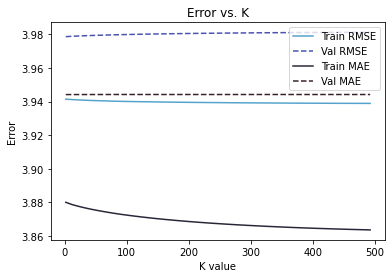

In [214]:
k_array = np.arange(2,500,10)

train_rmse_list, train_mae_list = [], []
val_rmse_list, val_mae_list = [], []

for k in k_array:
    
    filled, _ = compute_filled_matrix(train, k)
    train_rmse, train_mae = eval(train, filled)
    val_rmse, val_mae = eval(val, filled)

    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)
    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)

plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, '--', label = 'Val RMSE')
plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [167]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum index: ', k_array[val_rmse_list.index(min(val_rmse_list))])

Minimum RMSE on val: 0.9500794177452412, index: 3 
Minimum MAE on val: 0.7371871809840252, index: 1 
K at minimum index:  5


In [171]:
### test 
filled_nola, _ = compute_filled_matrix(train, 3)
test_rmse, test_mae = eval(test, filled_df = filled_nola)
print('-------------- Test -------------------')
print('RMSE: ', test_rmse)
print('MAE: ', test_mae)

-------------- Test -------------------
RMSE:  0.9349219643777589
MAE:  0.7300428670441587


We beat both baselines!! And that too using only 3 features ... which I am a bit uncertain about, perhaps the sparsity is so great that different values of K don't make any difference at all. I want to see if explicitly including other users will help improve performance 

### Finding Similarities

In [174]:
def find_sim_users(filled_df, user):
    """
    Takes in the SVD array and the user of interest for whom we want
    to make recommendations 
    """
    # Normalize the reconstructed matrix 
    avg_ratings = filled_df.mean(axis=1)
    user_ratings_centered = filled_df.sub(avg_ratings, axis=0)
    similarities = cosine_similarity(user_ratings_centered)
    cosine_similarity_df = pd.DataFrame(similarities, index=user_ratings_centered.index, columns=user_ratings_centered.index)
    #cosine_similarity_df.head()

    # find the most similar users and return a sorted series 
    cosine_similarity_series = cosine_similarity_df.loc[user]
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
    #print(ordered_similarities)

    return ordered_similarities

In [175]:
user_of_interest = 'NWUQCWiY0w97l2mcWq9GAQ'
ordered = find_sim_users(filled_nola, user_of_interest)
ordered

user_id
NWUQCWiY0w97l2mcWq9GAQ    1.000000
zb4zH5uiZuLJbd3iNTHryw    0.465927
Z_gVekPKQ2Syr-Nu5nS-QA    0.453326
Jo0enIIuw5N9-lBYzmS0fQ    0.383663
e7H8gzuGI39uhLGa5wRFeA    0.371303
                            ...   
gy0SuPY0OqrLBZD-63MVIQ   -0.318773
dXbDIjMlElEPZDMCLzC4WA   -0.319430
aIgdE3WP3x5JncRO0cMLQg   -0.331796
nW7cJrcesOALa2KT1riIhQ   -0.345863
LCcd6tEjC_Ty-aCVBHJjcw   -0.371228
Name: NWUQCWiY0w97l2mcWq9GAQ, Length: 1036, dtype: float64

In [176]:
top5 = ordered[:4].index.to_list()
weights = ordered[:4].values

sim_users = filled_nola[val.columns]
sim_users = sim_users.loc[sim_users.index.isin(top5)]
avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
user_of_interest = val.loc[val.index=='NWUQCWiY0w97l2mcWq9GAQ']

mask = user_of_interest.notna()
preds = avg_ratings.values[mask]
gt = user_of_interest.values[mask]

print(mean_squared_error(gt, preds, squared=False))
print(mean_squared_error(gt, preds))

4.204232155026595
17.675568013359573


In [177]:
def evaluateRecommendation(filled_df, split_df, user= None, avg_user = 5): 
    
    ordered = find_sim_users(filled_df, user)
    top5 = ordered[:avg_user].index.to_list()

    sim_users = filled_df[split_df.columns]
    sim_users = sim_users.loc[sim_users.index.isin(top5)]
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
    user_of_interest = split_df.loc[split_df.index==user]

    mask = user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)

    return rmse, mae

In [178]:
## entire pipeline
mse = []
mae = []
users_of_interest = val.index.values
for user in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_nola, val, user)
    mse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(mse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

Average mean squared error:  3.99248
Average mean absolute error:  3.99135


In [181]:
k_array = np.arange(2, 100)
train_rmse_list, train_mae_list = [], []
val_rmse_list, val_mae_list = [], []

for k in k_array:
    
    filled, _ = compute_filled_matrix(train, k)
    rmse = []
    mae = []
    users_of_interest = val.index.values
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, val, user)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))

#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, '--', label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

ValueError: operands could not be broadcast together with shapes (1036,1198) (1198,1) 

In [ ]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum index: ', k_array[val_rmse_list.index(min(val_rmse_list))])

We beat the average user baseline!!!!!!!!!
Lets see if changing the number of users we are averaging helps improve performance furthur 

In [ ]:
number_users = np.arange(2,11)
train_rmse_list, train_mae_list = [], []
val_rmse_list, val_mae_list = [], []

for numb in number_users:
    
    filled = compute_filled_matrix(nola_copy, 31)
    rmse = []
    mae = []
    users_of_interest = val.index.values
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, val, user, avg_user = numb)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))

#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(number_users, val_rmse_list, '--', label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(number_users, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [ ]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum index: ', number_users[val_rmse_list.index(min(val_rmse_list))])

Im not sure if this is because we found k = 31 gives the lowest error earlier with number_users = 5 or if this is actually the case. Do I want to try doing every possible combination or some subset of?

In [ ]:
cols = ['Bubble Tea', 'Buffets',
       'Cheese Shops', 'Ethiopian', 'Indian', 'Kosher', 'Street Vendors',
       'Wraps', 'Festivals', 'Cajun/Creole', 'Delis', 'Diners', 'Gastropubs',
       'Gluten-Free', 'Salad', 'Sandwiches', 'Seafood', 'Soup', 'Tex-Mex',
       'Alcohol', 'Markets', 'Coffee_and_Tea', 'Breakfast', 'Frozen_Desserts',
       'Latin American', 'Butcher', 'Hawaiian/Poke', 'Mediterranean',
       'East Asian', 'Vegan/Vegetarian', 'Southeast Asian', 'European',
       'Fast Food', 'Desserts', 'American']

user_cats_mapped = user_categories.copy() 

for col in cols: 
    user_cats_mapped[col] = np.where(user_categories[col] == 1, user_categories['stars'], np.nan)

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=38, id2word=dictionary, passes=10, workers=4)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

In [ ]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=df_grouped['tokenized'].values, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
def compute_coherence_values(corpus, dictionary, k, a=None, b=None):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
                                        #    alpha=a,
                                        #    eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_grouped['tokenized'].values, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# Topics range
min_topics = 5
max_topics = 60
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
model_results = []

for k in topics_range:
    # get the coherence score for the given parameters
    cv = compute_coherence_values(corpus=corpus_tfidf, dictionary=dictionary, k=k)
    # Save the model results
    model_results.append(cv)


plt.plot(topics_range, model_results)

In [ ]:
print(max(model_results))
print(model_results.index(max(model_results)))

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=38, id2word=dictionary, passes=100, workers=4)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

### Trying Other Methods to Incorporate Text

In [ ]:
df_grouped.head(3)

In [ ]:
data = df_grouped['tokenized'].values
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(data)]

In [ ]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=2,
                dm =1, 
                dm_mean = 1,
                workers = 4)
  
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
model.dv.most_similar('278', topn=10)

In [ ]:
df_grouped['lemmatized'].iloc[0]

In [ ]:
df_grouped['lemmatized'].iloc[278]

In [ ]:
# doc_tags is just a list of every unique document tag/beer_id
doc_tags = list(model.dv.index_to_key)# get the vector for each doc_tag
X = model[doc_tags]# Fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=2, n_iter = 2000, metric='cosine', random_state=42)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])# create a scatterplot of the resulting 2-dimensional data
plt.scatter(df['x'], df['y'])

## Lets try using the similar users we found here back in our RecSys

In [ ]:
sim_users_dict = {}
for row in df_grouped.itertuples(): 
    sim_users_dict[row.user_id] = model.dv.most_similar(str(row.Index), topn=50)

In [ ]:
def evaluateRecommendation(filled_df, split_df, user= '5tXRxr4T24Awl7vjyCvIcQ', avg_user = 2): 
    
    ordered = sim_users_dict[user]
    top5 = ordered[:avg_user]
    user_idx = []
    user_id_list = []
    for itm in top5:
        user_idx.append(itm[0])
    for idx in user_idx:
        user_id_list.append(df_grouped['user_id'].iloc[int(idx)])
    sim_users = filled_df[split_df.columns]
    sim_users = sim_users.loc[sim_users.index.isin(user_id_list)]
    #print(sim_users)
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T
    user_of_interest = split_df.loc[split_df.index==user]

    mask = user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)

    return rmse, mae

In [ ]:
val_pivot = makePivot(val)
filled, _ = compute_filled_matrix(train_pivot, 230)
rmse = []
mae = []
users_of_interest = val_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled, val_pivot, user_id, avg_user = 1)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

In [ ]:
k_array = np.arange(2, 327)
numb_users = np.arange(1,11)
k_rmse_list, k_mae_list = [], []

for k in k_array:
    val_rmse_list, val_mae_list = [], []
    for numb in numb_users: 
        filled = compute_filled_matrix(train_pivot, k)
        rmse = []
        mae = []
        users_of_interest = val_pivot.index.values
        for user in users_of_interest:
            user_rmse, user_mae = evaluateRecommendation(filled, val_pivot, user, avg_user = numb)
            rmse.append(user_rmse)
            mae.append(user_mae)

        val_rmse_list.append(np.mean(rmse))
        val_mae_list.append(np.mean(mae))

    k_rmse_list.append(val_rmse_list)
    k_mae_list.append(val_mae_list)


In [ ]:
#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, '--', label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, '--', label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [ ]:
len(df_grouped['tokenized'].to_list())

## Another attempt this time using truncated SVD

In [ ]:
tfidf_vec = TfidfVectorizer(analyzer='word', min_df = 2)

def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)    
train_tfidf = tfidf.fit_transform(df_grouped['tokenized'].to_list())

In [ ]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [3, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(train_tfidf)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
    

plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [ ]:
svd = TruncatedSVD(n_components=300)
tfidf_svd = svd.fit_transform(train_tfidf)

In [ ]:
tfidf_svd = pd.DataFrame(tfidf_svd, index = train_pivot.index)
tfidf_svd.head()

In [ ]:
filled_277, U = compute_filled_matrix(train_pivot, 230)
rmse = []
mae = []
users_of_interest = val_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_277, tfidf_svd, val_pivot, user_id, avg_user=2)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))

In [ ]:
n_comp = np.arange(2, 327)
val_rmse_list, val_mae_list = [], []

filled, _ = compute_filled_matrix(train_pivot, 230)
users_of_interest = val_pivot.index.values

for n in n_comp:
    
    svd = TruncatedSVD(n_components=n)
    tfidf_svd = svd.fit_transform(train_tfidf)
    tfidf_svd = pd.DataFrame(tfidf_svd, index = train_pivot.index)

    rmse = []
    mae = []
  
    for user in users_of_interest:
        user_rmse, user_mae = evaluateRecommendation(filled, tfidf_svd, val_pivot, user)
        rmse.append(user_rmse)
        mae.append(user_mae)

    val_rmse_list.append(np.mean(rmse))
    val_mae_list.append(np.mean(mae))

#plt.plot(k_array, train_rmse_list, label = 'Train RMSE')
plt.plot(k_array, val_rmse_list, label = 'Val RMSE')
#plt.plot(k_array, train_mae_list, label = 'Train MAE')
plt.plot(k_array, val_mae_list, label = 'Val MAE')
plt.legend(loc = 1)
plt.title('Error vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [ ]:
print('Minimum RMSE on val: {}, index: {} '.format(min(val_rmse_list), val_rmse_list.index(min(val_rmse_list))))
print('Minimum MAE on val: {}, index: {} '.format(min(val_mae_list), val_mae_list.index(min(val_mae_list))))
print('K at minimum rmse index: ', n_comp[val_rmse_list.index(min(val_rmse_list))])
print('K at minimum mae index: ', n_comp[val_mae_list.index(min(val_mae_list))])

In [ ]:
filled_277, _ = compute_filled_matrix(train_pivot, 41)
svd = TruncatedSVD(n_components=41)
tfidf_svd = svd.fit_transform(train_tfidf)
tfidf_svd = pd.DataFrame(tfidf_svd, index = train_pivot.index)

rmse = []
mae = []
users_of_interest = test_pivot.index.values
for user_id in users_of_interest:
    user_rmse, user_mae = evaluateRecommendation(filled_277, tfidf_svd, test_pivot, user_id, avg_user=2)
    rmse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(rmse),5))
print('Average mean absolute error: ', np.round(np.mean(mae),5))